## Problem Statement:
> To detect `Hatespeeches in Twitter` using NLP.


In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Load the dataset
df1 = pd.read_csv(r"/content/train_set.csv")
df1.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
# Checking rows and columns of DataFrame
print('Rows:',df1.shape[0], 'Columns:',df1.shape[1])

Rows: 31962 Columns: 3


In [5]:
# Checking null values in dataset
df1.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [7]:
# Checking Datatypes of each columns
df1.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [10]:
# Checking unique values in dataset using id column
len(df1.id.unique())

31962

0    29720
1     2242
Name: label, dtype: int64 



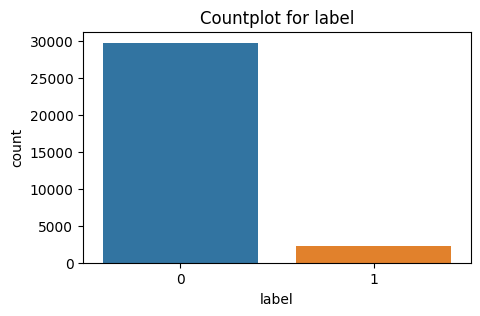

In [23]:
# Checking values for each label
print(df1.label.value_counts(),'\n')
plt.figure(figsize=(5,3))
sns.countplot(data=df1,x='label')
plt.title('Countplot for label')
plt.show()


**Summary Before Preprocessing the Dataset**

*   Number of `rows`: 31962, Number of `coulmns`: 3
*   Number of `unique values` in dataset: 31962
*   Since number of rows equals to number of unique values, so `no duplicate value` is present in the dataset
*   We can also see that there is `no null value` present in the dataset
*   The `DataTypes are also correct` for further preprocessing
*   From the plot we can see that the `dataset is imbalanced` and we can make it balanced while training model using SMOTE, but we will not be doing that in our model building.






## Preprocessing

In [24]:
# Selecting features that are essential for model development
df=df1[['tweet','label']]

In [25]:
# Function to preprocess the text
def preprocess_text(data):
    # using regular expression to remove unnecessary symbols
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    data = whitespace.sub(' ', data)
    data = user.sub('', data)
    data = re.sub(r"\[[^()]*\]","", data)
    data = re.sub("\d+", "", data)
    data = re.sub(r'[^\w\s]','',data)
    data = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", data)
    text = data.lower()

    # removing stop-words
    data = [word for word in data.split() if word not in list(stopwords.words('english'))]

    # word lemmatization
    sentence = []
    for word in data:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

# Applying the fuction to preprocess the data
df['processed_tweet'] = df['tweet'].apply(preprocess_text)


In [26]:
# Checking the preprocessing
df.head()

,tweet,label,processed_tweet
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drag kid dysfunct...
1,@user @user thanks for #lyft credit i can't us...,0,thank lyft credit cant use cause dont offer wh...
2,bihday your majesty,0,bihday majesty
3,#model i love u take with u all the time in ...,0,model love u take u time urð ðððð ððð
4,factsguide: society now #motivation,0,factsguide society motivation




*   We can see that the tweets have been preprocessed in the new column as processed_tweet



## Model Training

In [27]:
# Getting values to train and test model
X = df['processed_tweet'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)



*   We will be using TfIdf i.e. Term Frequency Inverse Document Frequency to convert our text to numerical values i.e vectors.
*   Based on the importance of each words in a document, we will assign values to each word.
*   Below image is for refence of what we will be doing.


>>   <img src="https://i.stack.imgur.com/DuXOo.png">

*   Now, we will use these vectors to train our model using Naive Bayes Machine Leaning Alogrithm.

In [28]:
# Initializing the TfidfVectorizer and MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()

# Create a pipeline combining the vectorizer and classifier
pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

In [29]:
# Defining the hyperparameters to search
parameters = {
    'vectorizer__max_features': [1000, 5000, 10000],  # Experimenting with different values
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Experimenting with different n-gram ranges
    'classifier__alpha': [0.1, 1.0, 10.0]  # Experimenting with different alpha values
}

# Performing grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# The best model
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=10000)),
                ('classifier', MultinomialNB(alpha=0.1))])





*   We have used 80% of the data to train the model, and we will test our model in the remaining 20% data.

*   We needed to convert our text to vectors as ML Alogrithms only work with numerical data.

*   For converting text to vectors we used TfidfVectorizer.

*   Best Parameters:

1.   For converting text to vectors using TfIdfVectorizer: max_features=10000
2.   For classifying the labels from these vector using MultinomialNB i.e. Naive Bayes: alpha=0.1  


## Evaluation of the trained model

In [30]:
# Predicting on the test set
y_pred = best_model.predict(X_test)

print('Confusion Matrix (Testing Data):')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


Confusion Matrix (Testing Data):
      0    1
0  5914   43
1   213  223
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5957
           1       0.84      0.51      0.64       436

    accuracy                           0.96      6393
   macro avg       0.90      0.75      0.81      6393
weighted avg       0.96      0.96      0.96      6393





*   We can say that we have built a good model as:


1.   Accuracy of the model: 96%
2.   Weighted avg for Precision of the model: 96%
3.   Weighted avg for Recall of the model: 96%
4.   Weighted avg for f1-score of the model: 96%

